# Project: Disaster Tweets 

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
#Loading the necessary libraries 

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re

import sklearn 
from sklearn import feature_extraction, model_selection, linear_model

import nltk 
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk import word_tokenize

import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from tensorflow.python.framework.random_seed import set_random_seed

import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, balanced_accuracy_score, f1_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

import scipy 
from scipy import sparse
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix

## Exploratory Data Analysis 

First, we look at the dataset. We can see that the two target classes are rather balanced in the training set (*real* disaster tweets: 3271, *fake* disaster tweets: 4342). This means that the ratio between class 0 (non-disaster tweets) and class 1 (disaster tweets) is 75:100. It does not seem we are dealing with an unbalanced classification problem. 

We also observe that the id column doesn't provide any useful information and can be dropped. 

Moreover, analysis on the location column reveals that 30% of values are missing, and those that are there are expressed in a variety of formats (city, state, city+state...). Since location wouldn't probably have helped much our classification, as disasters can unfortunately happen anywhere, we discard this column as well. 

The keyword column seems to be useful, even with missing values. 

In [2]:
#Loading the dataset (training + test set)

url1 = 'https://raw.githubusercontent.com/lila-97/Disaster-tweets-nlp/main/train.csv'
url2 = 'https://raw.githubusercontent.com/lila-97/Disaster-tweets-nlp/main/test.csv'
train_df = pd.read_csv(url1, sep=",")
test_df = pd.read_csv(url2, sep=",") 


In [3]:
# Exploring the dataset 

train_df.shape # The training set has 7613 rows and 5 columns (4 features + target)

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.shape  # The test set has 3263 rows and 4 columns (=features)

test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print("The real disaster tweets are {}".format(len(train_df[train_df['target'] == 1])))
print("The fake disaster tweets are {}".format(len(train_df[train_df['target'] == 0])))
print()
print("Hence, the two classes are balanced, although we have slightly more fake than real tweets")

print("The missing values for the keyword column are: {}".format(train_df["keyword"].isna().sum()))
print("There are {} unique keywords in the dataframe".format(len(train_df["keyword"].unique())))
print()


The real disaster tweets are 3271
The fake disaster tweets are 4342

Hence, the two classes are balanced, although we have slightly more fake than real tweets
The missing values for the keyword column are: 61
There are 222 unique keywords in the dataframe



C:\Users\elisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


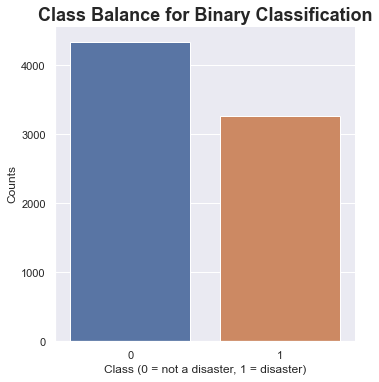

In [6]:
# counting the number of positive and negative tweets
sns.set(style="darkgrid", color_codes=True)
sns.catplot("target", data=train_df, kind="count", height=5)
plt.title("Class Balance for Binary Classification", size=18, weight="bold")
plt.xlabel("Class (0 = not a disaster, 1 = disaster)", size=12)
plt.ylabel("Counts", size=12)
plt.show()

In [7]:
#Find out if there is duplicates and nans in text column 

train_df.duplicated().sum()
train_df['text'].isna().any()

test_df.duplicated().sum()
test_df['text'].isna().any()


False

In [8]:
# Dropping location column because of too many different location formats and id columns 
# since it gives us no info 
print("The missing values for the location column are: {}".format(train_df["location"].isna().sum()))
print("There are {} unique locations in the dataframe".format(len(train_df["location"].unique())))
#train_df = train_df.drop('location', axis=1)
train_df = train_df.drop('id', axis=1)
train_df = train_df.drop('location', axis=1)


test_df = test_df.drop('location', axis=1)

The missing values for the location column are: 2533
There are 3342 unique locations in the dataframe


In [9]:
# Check n of unique keywords and whether they are the same for train and test sets

print (train_df.keyword.nunique(), test_df.keyword.nunique())
print (set(train_df.keyword.unique()) - set(test_df.keyword.unique()))

221 221
set()


| disaster tweets | non-disaster tweets |
|-----|----|
|outbreak|bodybags|
| derailment|armageddon |
|wreckage | harm|
|oil spill | deluge|
| typhoon|ruin |
|debris|wrecked|
|rescuers | explode|
| suicide bomb|siren |
|suicide bombing | twister|
|evacuated |fear |

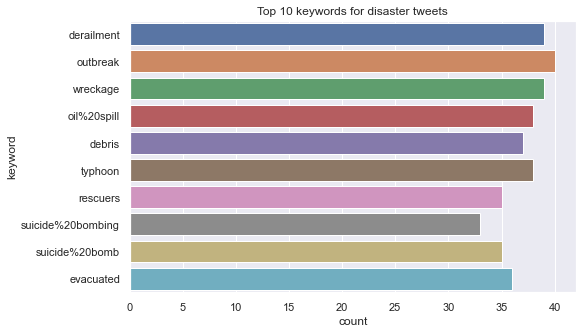

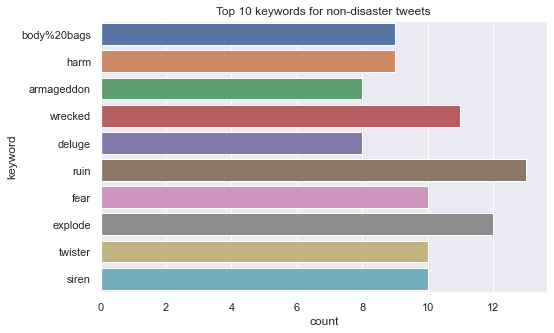

In [10]:
# The keywords are the same for training and test set 
# Below you can find the most common keywords for both disaster and non-disaster tweets

plt.figure(figsize=(8,5))
sns.countplot(y=train_df.keyword, order = train_df[train_df['target']==1].keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords for disaster tweets')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(y=test_df.keyword, order = train_df[train_df['target']==0].keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords for non-disaster tweets')
plt.show()

#Since top 10 keywords are different between disaster and non-disaster tweets, we keep this feature 

## Text Preprocessing 

We now turn to preprocess the text of the two columns left, 'text' and 'keyword'. 

Looking at the unique values of 'keyword' column, we can immediately see that there are special characters instead of spaces, so we remove those and put spaces instead. 

We also remove special characters and urls from both columns thanks to utility functions. 

While the column 'text' has no missing values in it, the 'keyword' column does. We set those to 0 and convert to strings. This shouldn't affect our analysis (none of the non-missing values have 0 in them so it should create a different token). 



In [11]:
#Keyword column:

#there are special characters instead of spaces, quick fix for both test and training set 

train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20',' ')

# Replace nans in keyword columns with zeroes 

train_df['keyword'] = train_df['keyword'].fillna(0)
train_df['keyword'] = train_df['keyword'].astype(str)
test_df['keyword'] = test_df['keyword'].fillna(0)
test_df['keyword'] = test_df['keyword'].astype(str)



In [12]:
# Utility functions for cleaning text and keyword columns 
def url_remover(text):
    text1 = re.sub(r'http?:\/\/.*[\r\n]*', "", text)
    text2 = re.sub(r'https:\/\/.*[\r\n]*', "", text1)
    text3 = " ".join(word for word in text2.split() if not word.startswith('@'))
    return text3.casefold().strip()

def special_chars_remover(text):
    text1 = re.sub(r"[^a-zA\s]", "", text)
    text2 = text1.replace("#", "").strip()
    #text2 = ' '.join(filter(str.isalnum, text2))
    return text2.strip()

# Applying functions to the training and test sets 
train_df['text'] = train_df.text.apply(url_remover)
train_df['keyword'] = train_df.keyword.apply(url_remover)

train_df['text'] = train_df.text.apply(special_chars_remover)
train_df['keyword'] = train_df.keyword.apply(special_chars_remover)

test_df["text"] = test_df.text.apply(url_remover)
test_df['keyword'] = test_df.keyword.apply(url_remover)

test_df["text"] = test_df.text.apply(special_chars_remover)
test_df['keyword'] = test_df.keyword.apply(special_chars_remover)

In [13]:
#Creating X_train, X_test and y_train

X_train = train_df[['text', 'keyword']]
y_train = train_df['target']

X_test = test_df[['text', 'keyword']]

In [14]:
print("X_train dim after processing: {}".format(X_train.shape))
print("y_train dim after processing: {}".format(y_train.shape))
print("X_test dim after processing: {}".format(X_test.shape))

X_train dim after processing: (7613, 2)
y_train dim after processing: (7613,)
X_test dim after processing: (3263, 2)


## Tokenization: CountVectorizer() and TfIdfVectorizer() 

Since different methods might work best with different types of tokenization, we propose two different kinds of tokenization, both implemented through the scikit-learn library. 

1. CountVectorizer(): considers only unigrams, bigrams and trigrams, maximum 200 features, only include values with >=6 occurences. It automatically performs tokenization and stopword removal. 
2. TfIdfVectorizer(): considers only unigrams and bigrams, maximum 10 features, only include values with >=6 occurences. It automatically performs tokenization and stopword removal.  

In [15]:
# Tf-idf for text and keyword columns


#Definition of TfIdf vectorizer object: only include >=10 occurrences and unigrams, bigrams and trigrams

tf_vec1 = TfidfVectorizer(min_df = 10, ngram_range = (1,3), max_features=2000, stop_words='english') 
tf_vec2 = TfidfVectorizer(min_df = 3, ngram_range = (1,3), max_features=500, stop_words='english') 

#Fitting the object on data for both text and keyword columns 
text_vectors_tr = tf_vec1.fit_transform(X_train['text'])
key_vectors_tr = tf_vec2.fit_transform(X_train['keyword'])
text_vectors_ts = tf_vec1.transform(X_test['text'])
key_vectors_ts = tf_vec2.transform(X_test['keyword'])

#Creating matrices 
tot_vectors_tr = scipy.sparse.hstack([text_vectors_tr, key_vectors_tr])
tot_vectors_ts = scipy.sparse.hstack([text_vectors_ts, key_vectors_ts])

#Convert matrices to arrays 
X_train_tfidf = pd.DataFrame(tot_vectors_tr.toarray())
X_test_tfidf = pd.DataFrame(tot_vectors_ts.toarray())
print (X_train_tfidf.shape)
print(X_test_tfidf.shape)

(7613, 2017)
(3263, 2017)


In [16]:
#Definition of CountVectorizer object: consider only unigrams, bigrams and trigrams, maximum 200 features,
# only include values with >=6 occurences
count_vectorizer1 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=200,
                                                            min_df = 6,
                                                          stop_words='english')

count_vectorizer2 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=10,
                                                            min_df = 2,
                                                          stop_words='english')

#Fit object on bith text and keyword column 
train_vectors1 = count_vectorizer1.fit_transform(X_train['text'])
train_vectors2 = count_vectorizer2.fit_transform(X_train['keyword'])

test_vectors1 = count_vectorizer1.transform(X_test['text'])
test_vectors2 = count_vectorizer2.transform(X_test['keyword'])

#Creating matrices 
tot_vectors_tr_cv = scipy.sparse.hstack([train_vectors1, train_vectors2])
tot_vectors_ts_cv = scipy.sparse.hstack([test_vectors1, test_vectors2])

#Convert matrices to arrays 
X_train_cv = pd.DataFrame(tot_vectors_tr_cv.toarray())
X_test_cv = pd.DataFrame(tot_vectors_ts_cv.toarray())
print (X_train_cv.shape)
print(X_test_cv.shape)

(7613, 210)
(3263, 210)


|Vectorizer Object / Parameters | ngram_range (lower and upper boundary of range of n-values for n-grams to be extracted) | max_features (build a vocabulary only considering the top-x features ordered by term frequency in the corpus) | min_df (ignore terms with document frequency lower than the given threshold when building vocab.) | stop_words (list of stopwords to be removed) |
|-----|------|------|-----|-----|
|CountVectorizer for 'text' | (1,3) | 200 | 6 | 'english' |
|CountVectorizer for 'keyword' | (1,3) | 10  | 2 | 'english' |
|TfIdfVectorizer for 'text' | (1,3) | 1500 | 20 | 'english' |
|TfIdfVectorizer for 'keyword' | (1,3) | 200 | 6 | 'english' |

## Logistic Regression

We apply Logistic regression both with CountVectorizer and TfIdfVectorizer tokenization. Best model parameters are found through grid-search with 10-fold cross validation. 

* Approximate validation set accuracy with TfIdfVectorizer() tokenization: 79% (C=1, fit_intercept=True)

* Approximate validation set accuracy with CountVectorizer() tokenization: 74% (C=0.5, fit_intercept=True)

In [17]:
## TFIDF TOKENIZATION 

#Split in training and validation sets 
X_train_lr1, X_val_lr1, y_train_lr1, y_val_lr1 = train_test_split(X_train_tfidf, y_train, 
                                                  train_size = 0.7, random_state = 123)

In [18]:
# Create parameter grid
param_grid_test = {
    'C': [0.1, 0.5, 1, 5, 10, 15, 20],
    'fit_intercept': [True, False]
}

# Create classifier object 
lr = LogisticRegression(max_iter = 300, random_state=123)

# Create grid-search object 
clf_lr = GridSearchCV(estimator= lr, param_grid=param_grid_test, 
                   cv = 10, scoring = "accuracy")

In [19]:
clf_lr.fit(X_train_lr1, y_train_lr1)

y_train_pred_lr1 = clf_lr.predict(X_train_lr1)
y_val_pred_lr1 = clf_lr.predict(X_val_lr1)


print(clf_lr.best_params_)
print(clf_lr.best_score_)

print(f"Logistic regression.\tBalanced accuracy on training set: {balanced_accuracy_score(y_train_pred_lr1, y_train_lr1)}")
print(f"Logistic regression.\tF1-score on training set: {f1_score(y_train_pred_lr1, y_train_lr1)}")
print(f"Logistic regression.\tBalanced accuracy on validation set: {balanced_accuracy_score(y_val_pred_lr1, y_val_lr1)}")
print(f"Logistic regression.\tF1-score on validation set: {f1_score(y_val_pred_lr1, y_val_lr1)}")

{'C': 1, 'fit_intercept': True}
0.7841992410670203
Logistic regression.	Balanced accuracy on training set: 0.8451367719929633
Logistic regression.	F1-score on training set: 0.8057221965851408
Logistic regression.	Balanced accuracy on validation set: 0.7871592821656697
Logistic regression.	F1-score on validation set: 0.7388949079089926


In [20]:
## COUNTVECTORIZER TOKENIZATION 

X_train_lr2, X_val_lr2, y_train_lr2, y_val_lr2 = train_test_split(X_train_cv, y_train, 
                                                  train_size = 0.7, random_state = 123)

In [21]:
clf_lr.fit(X_train_lr2, y_train_lr2)

y_train_pred_lr2 = clf_lr.predict(X_train_lr2)
y_val_pred_lr2 = clf_lr.predict(X_val_lr2)


print(clf_lr.best_params_)
print(clf_lr.best_score_)
print(f"Logistic regression.\tBalanced accuracy on training set: {balanced_accuracy_score(y_train_pred_lr2, y_train_lr2)}")
print(f"Logistic regression.\tF1-score on training set: {f1_score(y_train_pred_lr2, y_train_lr2)}")
print(f"Logistic regression.\tBalanced accuracy on validation set: {balanced_accuracy_score(y_val_pred_lr2, y_val_lr2)}")
print(f"Logistic regression.\tF1-score on validation set: {f1_score(y_val_pred_lr2, y_val_lr2)}")

{'C': 0.5, 'fit_intercept': True}
0.7374730212021611
Logistic regression.	Balanced accuracy on training set: 0.769907285297124
Logistic regression.	F1-score on training set: 0.6635873749037722
Logistic regression.	Balanced accuracy on validation set: 0.7463708705088016
Logistic regression.	F1-score on validation set: 0.6385542168674698


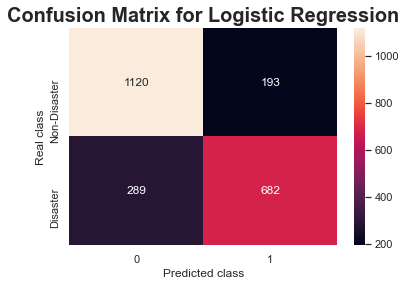

In [22]:
# Confusion matrix for best model (tfidf, c=1, intercept=true)

conf_lr = confusion_matrix(y_val_lr1, y_val_pred_lr1, labels=[0,1])

labels= ["Non-Disaster", "Disaster"]



sns.heatmap(conf_lr, annot=True, fmt='g')
plt.xlabel("Predicted class")
plt.ylabel("Real class")
plt.title("Confusion Matrix for Logistic Regression", size=20, weight="bold")
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

## K-Nearest-Neighbours 


We apply KNN algorithm both with CountVectorizer and TfIdfVectorizer tokenization. Best model parameter K is found by first plotting accuracies for values of K ranging from 1 to 60. 

Then, we implement the model with the best value of K found 

* TfIdfVectorizer() tokenization: best K seems 33 with circa 75% max accuracy on validation set. 

* CountVectorizer() tokenization: best K seems 15, but accuracy never goes over 70%. Model discarded

Hence, we fit a KNN model with K=33 on training and validation sets transformed with TfIdfVectorizer(). 

Accuracy reached on validation set is around 74%, and all other metrics confirm that KNN is suboptimal wrt LogisticRegression. 

In [23]:
## TFIDF TRANSFORMATION 

#Split in training and validation sets 
X_train_knn1, X_val_knn1, y_train_knn1, y_val_knn1 = train_test_split(X_train_tfidf, y_train, 
                                                  train_size = 0.7, random_state = 123)

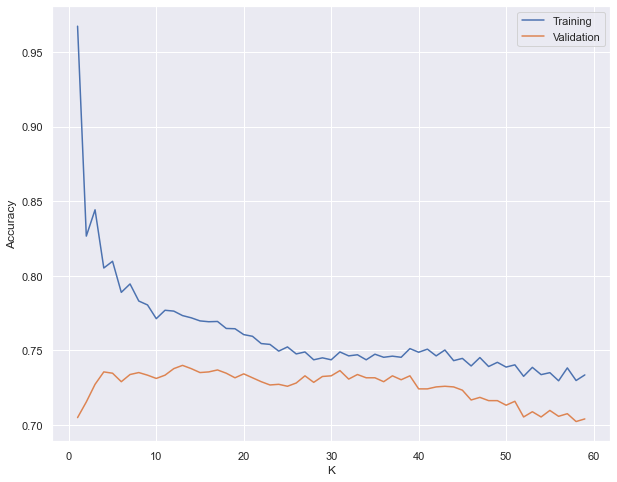

In [24]:


accuracy_val_train = []
accuracy_val_val = []
error_val_train = []
error_val_val = []
k_values = range(1, 60)


for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_knn1, y_train_knn1)
  y_pred_train_knn1 = model.predict(X_train_knn1)
  y_pred_val_knn1 = model.predict(X_val_knn1)
  accuracy_val_train.append(accuracy_score(y_pred_train_knn1, y_train_knn1))
  accuracy_val_val.append(accuracy_score(y_pred_val_knn1, y_val_knn1))
  error_val_train.append(mean_squared_error(y_pred_train_knn1, y_train_knn1))
  error_val_val.append(mean_squared_error(y_pred_val_knn1, y_val_knn1))

    
fig = plt.figure(figsize=(10,8))
plt.plot(k_values, accuracy_val_train, label="Training")
plt.plot(k_values, accuracy_val_val, label="Validation")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

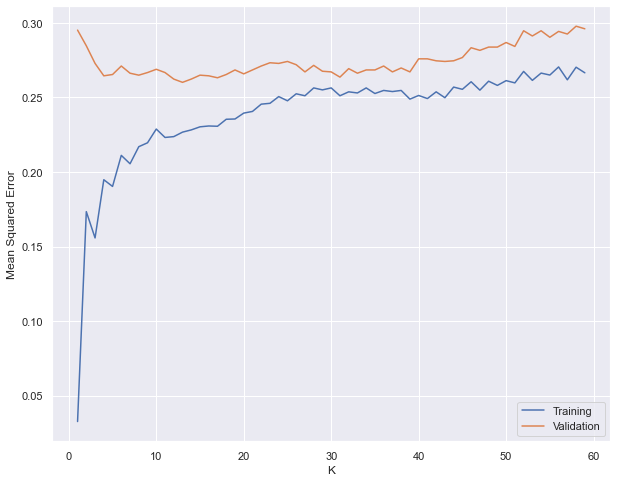

In [25]:
fig = plt.figure(figsize=(10,8))
plt.plot(k_values, error_val_train, label="Training")
plt.plot(k_values, error_val_val, label="Validation")
plt.xlabel("K")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

In [26]:
## COUNTVECTORIZER TOKENIZATION 

X_train_knn2, X_val_knn2, y_train_knn2, y_val_knn2 = train_test_split(X_train_cv, y_train, 
                                                  train_size = 0.7, random_state = 123)

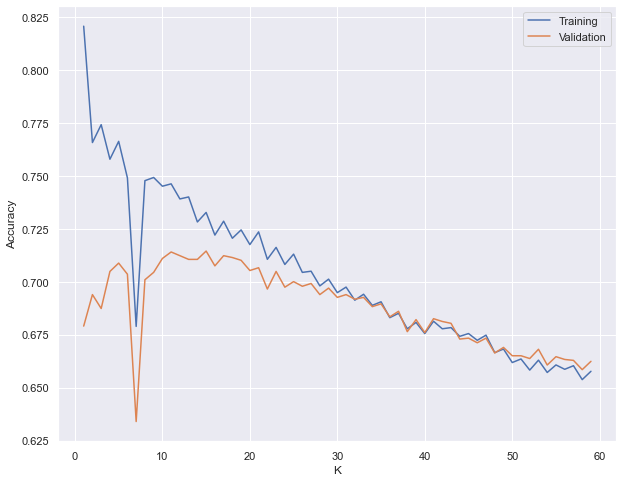

In [27]:

accuracy_val_train = []
accuracy_val_val = []
error_val_train = []
error_val_val = []
k_values = range(1, 60)


for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train_knn2, y_train_knn2)
  y_pred_train_knn2 = model.predict(X_train_knn2)
  y_pred_val_knn2 = model.predict(X_val_knn2)
  accuracy_val_train.append(accuracy_score(y_pred_train_knn2, y_train_knn2))
  accuracy_val_val.append(accuracy_score(y_pred_val_knn2, y_val_knn2))
  error_val_train.append(mean_squared_error(y_pred_train_knn1, y_train_knn1))
  error_val_val.append(mean_squared_error(y_pred_val_knn1, y_val_knn1))

    
fig = plt.figure(figsize=(10,8))
plt.plot(k_values, accuracy_val_train, label="Training")
plt.plot(k_values, accuracy_val_val, label="Validation")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
# Fitting optimal KNN model found 

X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_train_tfidf, y_train, 
                                                  train_size = 0.7, random_state = 123)

knn_model = KNeighborsClassifier(n_neighbors=13)
knn_model.fit(X_train_knn, y_train_knn)

y_tr_knn_pred = knn_model.predict(X_train_knn)
y_val_knn_pred = knn_model.predict(X_val_knn)

print(f"KNN.\tBalanced accuracy on training set: {balanced_accuracy_score(y_tr_knn_pred, y_train_knn)}")
print(f"KNN.\tF1-score on training set: {f1_score(y_tr_knn_pred, y_train_knn)}")
print(f"KNN.\tBalanced accuracy on validation set: {balanced_accuracy_score(y_val_knn_pred, y_val_knn)}")
print(f"KNN.\tF1-score on validation set: {f1_score(y_tr_knn_pred, y_train_knn)}")

KNN.	Balanced accuracy on training set: 0.7718746767860136
KNN.	F1-score on training set: 0.7226813590449954
KNN.	Balanced accuracy on validation set: 0.7348710443452633
KNN.	F1-score on validation set: 0.7226813590449954


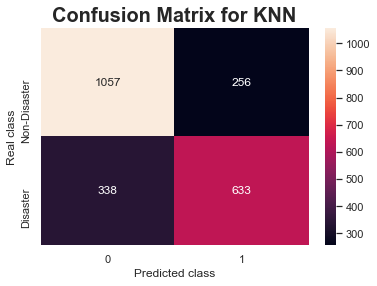

In [29]:
# Confusion matrix for best model (tfidf, c=1, intercept=true)

conf_lr = confusion_matrix(y_val_knn, y_val_knn_pred, labels=[0,1])

labels= ["Non-Disaster", "Disaster"]

sns.heatmap(conf_lr, annot=True, fmt='g')
plt.xlabel("Predicted class")
plt.ylabel("Real class")
plt.title("Confusion Matrix for KNN", size=20, weight="bold")
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

## Neural Networks

In [30]:
# We use the function defined in class to find the best model for out input 

from keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import optimizers


opt = tensorflow.keras.optimizers.SGD(learning_rate=0.015, momentum=0.005, nesterov=True, name="SGD")


# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 50, #number of epochs with no improvement
                   verbose=1)

def MLP_definer2(n_layers, input_size, n_classes):
    #seed
    np.random.seed(123)
    set_random_seed(2)
    
    #define a sequential model
    model = Sequential()

    if n_layers == 0:
        
        
        model.add(Dense(input_dim= input_size, units = input_size, activation= 'relu'))
    else:
        #define the first layer 
        for i in range(n_layers):
            
            if i == 0: #input layer
                model.add(Dense(units = input_size, input_dim = input_size, activation='relu'))
            elif i == 1:
                initializer = initializers.HeNormal(seed=123)
                model.add(Dense(units = input_size*2, input_dim = input_size, activation='relu',
                                kernel_initializer=initializer,
                                kernel_regularizer = tensorflow.keras.regularizers.l1(l1=0.0005)))
            elif i == 2:
                initializer = initializers.HeNormal(seed=123)
                model.add(Dense(units = input_size*2.5, activation = 'relu', kernel_initializer=initializer,
                                kernel_regularizer=tensorflow.keras.regularizers.l1(l1=0.0005)))
            else: 
                initializer = initializers.HeNormal(seed=123)
                model.add(Dense(units = input_size*3, activation = 'relu', kernel_initializer=initializer,
                                kernel_regularizer=tensorflow.keras.regularizers.l1(l1=0.0005)))
            

    model.add(Dense(units = 1, activation= 'sigmoid')) #apparently sigmoid is better for binary classification

    # Configure the model and start training
    model.compile(loss='binary_crossentropy', #loss metric
                  optimizer=opt,  #optimizer
                  metrics=['accuracy']) #displayed metric

    return model

#kernel_regularizer=tensorflow.keras.regularizers.l1(0.00001)

In [31]:
## COUNTVEC VECTORIZATION 

# Scaling the data 



from sklearn.preprocessing import MinMaxScaler
#define the scaler
scaler = MinMaxScaler()
#fit the scaler on the training

#trasform the input
scaler = scaler.fit(X_train_cv)
X_train_cv_nn = scaler.transform(X_train_cv)

In [32]:
#Splitting in training and validation set 

X_train_nn1, X_val_nn1, y_train_nn1, y_val_nn1 = train_test_split(X_train_cv_nn, y_train, 
                                                  train_size = 0.8, random_state = 123) 

feature_vector_length=X_train_nn1.shape[1]

In [33]:
nlayers = [0,1,2,3]

top=0
accuracies = []
for nl in nlayers:
    #create the MLP
    m = MLP_definer2(n_layers= nl, input_size=feature_vector_length, n_classes= 2)
    #K.set_value(m.optimizer.learning_rate, 0.015)
    print(m.summary())

    #train our model
    neu_1 = m.fit(X_train_nn1, y_train_nn1, epochs=500, 
          batch_size=50, verbose=0, validation_split=0.1, 
          callbacks=[es])
    print(f"N layers:{nl}\t\tTrain ACC:{neu_1.history['accuracy'][-1]:.8f}\tVal ACC:{neu_1.history['val_accuracy'][-1]:.8f}")
    accuracies.append(neu_1.history['val_accuracy'][-1])
    print("\n\n\n\n")

    y_train_pred_nn1 = m.predict(X_train_nn1).argmax(axis = 1) 
    y_val_pred_nn1 = m.predict(X_val_nn1).argmax(axis = 1)
    
best = max(accuracies)

print("The best NN model has an accuracy of {}".format(best))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 210)               44310     
                                                                 
 dense_1 (Dense)             (None, 1)                 211       
                                                                 
Total params: 44,521
Trainable params: 44,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00220: early stopping
N layers:0		Train ACC:0.76153988	Val ACC:0.73070610





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 210)               44310     
                                                                 
 dense_3 (Dense)             (None, 1)                 211       
      

In [34]:
nlayers = [2]

top=0
accuracies = []
for nl in nlayers:
    #create the MLP
    m = MLP_definer2(n_layers= nl, input_size=feature_vector_length, n_classes= 2)
    K.set_value(m.optimizer.learning_rate, 0.015)
    print(m.summary())

    #train our model
    neu_1 = m.fit(X_train_nn1, y_train_nn1, epochs=500, 
          batch_size=50, verbose=0, validation_split=0.1, 
          callbacks=[es])
    print(f"N layers:{nl}\t\tTrain ACC:{neu_1.history['accuracy'][-1]:.8f}\tVal ACC:{neu_1.history['val_accuracy'][-1]:.8f}")
    accuracies.append(neu_1.history['val_accuracy'][-1])
    print("\n\n\n\n")

    y_train_pred_nn1 = m.predict(X_train_nn1).argmax(axis = 1) 
    y_val_pred_nn1 = m.predict(X_val_nn1).argmax(axis = 1)
    
best = max(accuracies)

print("The best NN model has an accuracy of {}".format(best))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 210)               44310     
                                                                 
 dense_12 (Dense)            (None, 420)               88620     
                                                                 
 dense_13 (Dense)            (None, 1)                 421       
                                                                 
Total params: 133,351
Trainable params: 133,351
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00399: early stopping
N layers:2		Train ACC:0.78033203	Val ACC:0.74055827





The best NN model has an accuracy of 0.7405582666397095


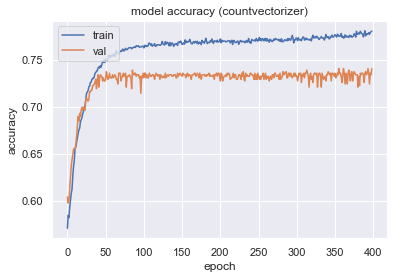

In [35]:
# summarize history for accuracy
plt.plot(neu_1.history['accuracy'])
plt.plot(neu_1.history['val_accuracy'])
plt.title('model accuracy (countvectorizer)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

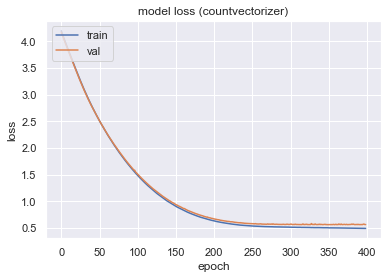

In [36]:
# summarize history for loss
plt.plot(neu_1.history['loss'])
plt.plot(neu_1.history['val_loss'])
plt.title('model loss (countvectorizer)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
type(X_test_tfidf)

pandas.core.frame.DataFrame

In [38]:
# Scaling the data 

X_test_tfidf = pd.DataFrame(X_test_tfidf)

from sklearn.preprocessing import MinMaxScaler
#define the scaler
scaler1 = MinMaxScaler()
#fit the scaler on the training

#trasform the input
X_train_tfidf_nn = scaler1.fit_transform(X_train_tfidf)


#Splitting in training and validation set 

X_train_nn2, X_val_nn2, y_train_nn2, y_val_nn2 = train_test_split(X_train_tfidf_nn, y_train, 
                                                  train_size = 0.8, random_state = 123) 

feature_vector_length=X_train_nn2.shape[1]

In [39]:
def MLP_definer3(n_layers, input_size, n_classes):
    #seed
    np.random.seed(123)
    set_random_seed(2)
    
    #define a sequential model
    model = Sequential()

    if n_layers == 0:
        model.add(Dense(input_dim= input_size, units = input_size, activation= 'sigmoid'))
    else:
        #define the first layer 
        for i in range(n_layers):
    
    
        
            if i == 0: #input layer
                    model.add(Dense(units = input_size, input_dim = input_size, activation='relu'))
            else:
                initializer = initializers.HeNormal(seed=123)
                model.add(Dense(units = input_size, input_dim = input_size, activation='relu',
                                kernel_initializer=initializer,
                                kernel_regularizer = tensorflow.keras.regularizers.l1(l1=0.0005)))
            
            

    model.add(Dense(units = 1, activation= 'sigmoid')) #apparently sigmoid is better for binary classification

    # Configure the model and start training
    model.compile(loss='binary_crossentropy', #loss metric
              optimizer= opt,  #optimizer
              metrics=['accuracy']) #displayed metric

    return model

In [40]:
## TFIDF VECTORIZATION 



nlayers = [0,1,2]
top=0
accuracies =[]
for nl in nlayers:
    #create the MLP
    m = MLP_definer3(n_layers= nl, input_size=feature_vector_length, n_classes= 2)
    #K.set_value(m.optimizer.learning_rate, 0.015)
    print(m.summary())

    #train our model
    neu_2 = m.fit(X_train_nn2, y_train_nn2, epochs=500, 
          batch_size=75, verbose=0, validation_split=0.3, 
          callbacks=[es])
    
    print(f"N layers:{nl}\t\tTrain ACC:{neu_2.history['accuracy'][-1]:.8f}\tVal ACC:{neu_2.history['val_accuracy'][-1]:.8f}")
    y_train_pred_nn2 = m.predict(X_train_nn2).argmax(axis = 1) 
    y_val_pred_nn2 = m.predict(X_val_nn2).argmax(axis = 1)
    accuracies.append(neu_2.history['val_accuracy'][-1])

    best = max(accuracies)

print("The best NN model has an accuracy of {}".format(best))   

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 2017)              4070306   
                                                                 
 dense_15 (Dense)            (None, 1)                 2018      
                                                                 
Total params: 4,072,324
Trainable params: 4,072,324
Non-trainable params: 0
_________________________________________________________________
None
N layers:0		Train ACC:0.81609195	Val ACC:0.79091406
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 2017)              4070306   
                                                                 
 dense_17 (Dense)            (None, 1)                 2018      
                               

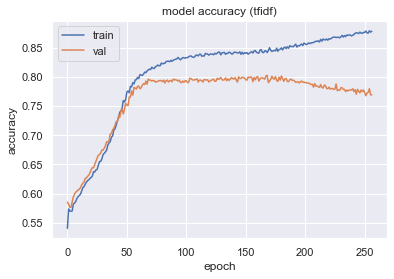

In [41]:
# summarize history for accuracy
plt.plot(neu_2.history['accuracy'])
plt.plot(neu_2.history['val_accuracy'])
plt.title('model accuracy (tfidf)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

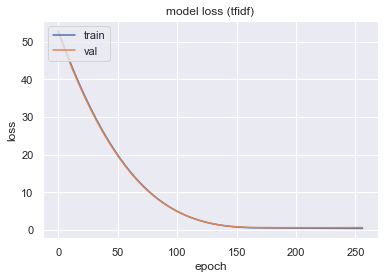

In [42]:
# summarize history for loss
plt.plot(neu_2.history['loss'])
plt.plot(neu_2.history['val_loss'])
plt.title('model loss (tfidf)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
X_test_tfidf_nn = scaler1.transform(X_train_tfidf)

X_test_tfidf_nn.shape

(7613, 2017)

In [44]:
#create the MLP for best model 
feature_vector_length1 = X_train_tfidf_nn.shape[1]
m = MLP_definer3(n_layers= 1, input_size=feature_vector_length1, n_classes= 2)

# Retrain best model using whole training set (training + validation)
neu_3 = m.fit(X_train_tfidf_nn, y_train, epochs=500, 
          batch_size=75, verbose=0, validation_split=0.2, 
          callbacks=[es])

y_pred_train_nn = m.predict(X_train_tfidf_nn).argmax(axis = 1)
print(f"Train ACC:{neu_3.history['accuracy'][-1]:.8f}\tVal ACC:{neu_3.history['val_accuracy'][-1]:.8f}")

Epoch 00273: early stopping
Train ACC:0.87832510	Val ACC:0.76099801


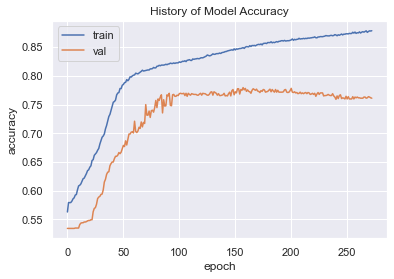

In [45]:
# summarize history for accuracy
plt.plot(neu_3.history['accuracy'])
plt.plot(neu_3.history['val_accuracy'])
plt.title('History of Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

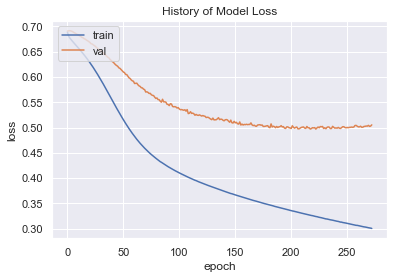

In [46]:
# summarize history for loss
plt.plot(neu_3.history['loss'])
plt.plot(neu_3.history['val_loss'])
plt.title('History of Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## SVC 

In [47]:
#train the svc
svc_grid_params = {'C': (1, 3, 5, 10, 15), 'kernel': ('rbf', 'linear')}

clf_svc = SVC(random_state= 123)

In [48]:
## COUNTVECTORIZER TOKENIZATION 

X_train_svc1, X_val_svc1, y_train_svc1, y_val_svc1 = train_test_split(X_train_cv, y_train, 
                                                  train_size = 0.7, random_state = 123)

In [49]:
svc_cl1 = GridSearchCV(clf_svc, svc_grid_params, n_jobs= -1, cv = 10, scoring = 'accuracy')
svc_cl1.fit(X_train_svc1, y_train_svc1)

y_pred_train_svc1 = svc_cl1.predict(X_train_svc1)
y_pred_val_svc1 = svc_cl1.predict(X_val_svc1)

print(f"Best parameters for SVC are: {svc_cl1.best_params_}\n")

print(f"SVC.\tBalanced accuracy on training set: {balanced_accuracy_score(y_pred_train_svc1, y_train_svc1)}")
print(f"SVC.\tF1-score on training set: {f1_score(y_pred_train_svc1, y_train_svc1)}")
print(f"SVC.\tBalanced accuracy on validation set: {balanced_accuracy_score(y_pred_val_svc1, y_val_svc1)}")
print(f"SVC.\tF1-score on validation set: {f1_score(y_pred_val_svc1, y_val_svc1)}")

Best parameters for SVC are: {'C': 1, 'kernel': 'rbf'}

SVC.	Balanced accuracy on training set: 0.8365709863726045
SVC.	F1-score on training set: 0.7429739397036281
SVC.	Balanced accuracy on validation set: 0.7580639536911113
SVC.	F1-score on validation set: 0.6599286563614746


In [50]:
## TFIDF TOKENIZATION 

svc_grid_params2 = {'C': (1, 3, 5, 10, 15), 'fit_intercept': (True, False)}
clf_svc2 = LinearSVC(random_state= 123)

X_train_svc2, X_val_svc2, y_train_svc2, y_val_svc2 = train_test_split(X_train_tfidf, y_train, 
                                                  train_size = 0.7, random_state = 123)

In [51]:
svc_cl2 = GridSearchCV(clf_svc2, svc_grid_params2, n_jobs= -1, cv = 10, scoring = 'accuracy')
svc_cl2.fit(X_train_svc2, y_train_svc2)

y_pred_train_svc2 = svc_cl2.predict(X_train_svc2)
y_pred_val_svc2 = svc_cl2.predict(X_val_svc2)

print(f"Best parameters for SVC are: {svc_cl2.best_params_}\n")

print(f"SVC.\tBalanced accuracy on training set: {balanced_accuracy_score(y_pred_train_svc2, y_train_svc2)}")
print(f"SVC.\tF1-score on training set: {f1_score(y_pred_train_svc2, y_train_svc2)}")
print(f"SVC.\tBalanced accuracy on validation set: {balanced_accuracy_score(y_pred_val_svc2, y_val_svc2)}")
print(f"SVC.\tF1-score on validation set: {f1_score(y_pred_val_svc2, y_val_svc2)}")

Best parameters for SVC are: {'C': 1, 'fit_intercept': True}

SVC.	Balanced accuracy on training set: 0.881171605307439
SVC.	F1-score on training set: 0.8529879572824358
SVC.	Balanced accuracy on validation set: 0.7760552787061952
SVC.	F1-score on validation set: 0.7299035369774921


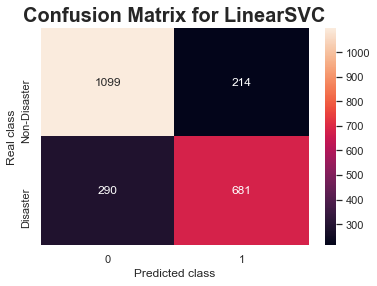

In [52]:
# Confusion matrix for best model (tfidf, c=1, intercept=true)

conf_svc = confusion_matrix(y_val_svc2, y_pred_val_svc2, labels=[0,1])

labels= ["Non-Disaster", "Disaster"]

sns.heatmap(conf_svc, annot=True, fmt='g')
plt.xlabel("Predicted class")
plt.ylabel("Real class")
plt.title("Confusion Matrix for LinearSVC", size=20, weight="bold")
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

## Random Forest 

In [53]:
#train the random forest
rf_grid_params = {
    'n_estimators': (50, 75, 100, 125, 150, 200),
    'criterion': ['gini','entropy'],
    'max_depth': (None, 1,3,5,10,50),
}

In [54]:
## COUNTVECTORIZER TOKENIZATION 

X_train_rf1, X_val_rf1, y_train_rf1, y_val_rf1 = train_test_split(X_train_cv, y_train, 
                                                  train_size = 0.7, random_state = 123)


RF = RandomForestClassifier(random_state= 123)
clf_rf1 = GridSearchCV(RF, rf_grid_params, n_jobs= -1, cv = 10)
clf_rf1.fit(X_train_rf1, y_train_rf1)

y_train_pred_rf1 = clf_rf1.predict(X_train_rf1)
y_val_pred_rf1 = clf_rf1.predict(X_val_rf1)

print(f"Best parameters for Random forest are: {clf_rf1.best_params_}\n")

print(f"Random forest.\tBalanced accuracy on training set: {balanced_accuracy_score(y_train_pred_rf1, y_train_rf1)}")
print(f"Random forest.\tF1-score on training set: {f1_score(y_train_pred_rf1, y_train_rf1)}")
print(f"Random forest.\tBalanced accuracy on validation set: {balanced_accuracy_score(y_val_pred_rf1, y_val_rf1)}")
print(f"Random forest.\tF1-score on validation set: {f1_score(y_val_pred_rf1, y_val_rf1)}")

Best parameters for Random forest are: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}

Random forest.	Balanced accuracy on training set: 0.8629208472474726
Random forest.	F1-score on training set: 0.7978410206084396
Random forest.	Balanced accuracy on validation set: 0.7392552721207607
Random forest.	F1-score on validation set: 0.6527777777777779


In [ ]:
## TFIDF TOKENIZATION 

X_train_rf2, X_val_rf2, y_train_rf2, y_val_rf2 = train_test_split(X_train_tfidf, y_train, 
                                                  train_size = 0.7, random_state = 123)



clf_rf2 = GridSearchCV(RF, rf_grid_params, n_jobs= -1, cv = 10)
clf_rf2.fit(X_train_rf2, y_train_rf2)

y_train_pred_rf2 = clf_rf2.predict(X_train_rf2)
y_val_pred_rf2 = clf_rf2.predict(X_val_rf2)

print(f"Best parameters for Random forest are: {clf_rf2.best_params_}\n")

print(f"Random forest.\tBalanced accuracy on training set: {balanced_accuracy_score(y_train_pred_rf2, y_train_rf2)}")
print(f"Random forest.\tF1-score on training set: {f1_score(y_train_pred_rf2, y_train_rf2)}")
print(f"Random forest.\tBalanced accuracy on validation set: {balanced_accuracy_score(y_val_pred_rf2, y_val_rf2)}")
print(f"Random forest.\tF1-score on validation set: {f1_score(y_val_pred_rf2, y_val_rf2)}")

In [ ]:
# Confusion matrix for best model (tfidf, c=1, intercept=true)

conf_svc = confusion_matrix(y_val_svc2, y_pred_val_svc2, labels=[0,1])

labels= ["Non-Disaster", "Disaster"]

sns.heatmap(conf_svc, annot=True, fmt='g')
plt.xlabel("Predicted class")
plt.ylabel("Real class")
plt.title("Confusion Matrix for LinearSVC", size=20, weight="bold")
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

## Summary statistics for model selection 

|   Model   | Parameters | Values |
| --------  | ---------- | ------ |
| Logistic Regression (CountVec)  | C <br> fit_intercept |  [0.1,0.5,**1**,5,10,15,20] <br> [**True**, False] |
| Logistic Regression (TfIdf)  | C <br> fit_intercept |  [0.1,**0.5**,1,5,10,15,20] <br> [**True**, False] | 
| SVC (CountVec)| C <br> kernel | [**1**,3,5,10,15] <br> [linear, **rbf**] |
| LinearSVC (TfIdf)| C <br> fit_intercept | [**1**,3,5,10,15] <br> [**True**, False] |
| Neural Network | n. hidden layers <br> optimizer <br> activation function in hidden layers <br> learning rate| [0,**1**,2,3] <br> [SGD, **SGD+Nesterov's momentum(0.0005)**, Adagrad, Adam] <br> [**relu**, softmax, elu, exponential] <br> [0.001,0.002,0.003,0.006,0.008,0.009,0.01,**0.015**,0.2,0.3]|
| KNN (TfIdf) | K | [1,2,...,**13**,...,60]]|
| Random Forest (CountVec)| n_estimators <br> criterion <br> max_depth| [1,5,10,15,17,19,20,**21**,22,25] <br> [gini, **entropy**] <br> [None,1,3,5,10,**50**]|
| Random Forest (TfIdf)| n_estimators <br> criterion <br> max_depth| [1,5,10,15,17,19,20,**21**,22,25] <br> [**gini**, entropy] <br> [**None**,1,3,5,10,50]|

|   Model   | Accuracy | F-1 |
| --------  | ----- | ----|
| Logistic Regression (CountVec)  | **78.7** | 73.8 |
| Logistic Regression (TfIdf) | 74.6 |63.8  |
| Neural Network (TfIdf, on whole training set)  | 76.1 | / |
| SVC (CountVec)  | 75.8 |  66.0|
| LinearSVC (TfIdf)  | **77.6** | 73.0 |
| KNN (TfIdf)  | 73.5 | 72.3 |
| Random Forest (CountVec)| 75.9 | 60.8 |
| Random Forest (TfIdf)| 75.6  |  70.7|